In [ ]:
!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic as RQ, WhiteKernel
!apt-get install git
!git clone https://github.com/afyanyan/SN.git
%cd SN/Database/Process_Data

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Cloning into 'SN'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 383 (delta 91), reused 127 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (383/383), 396.60 KiB | 2.17 MiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/SN/Database/Process_Data


In [ ]:
print("Which SN LightCurve do you wish to view?")
SN_name = input("enter SN name- ")
file = SN_name + "_frg_r.csv"
frg_r = pd.read_csv(file)
frg_r

# training data set
X = frg_r[['MJD']].values
y = frg_r[['unforced_mag']].values

Which SN LightCurve do you wish to view?
enter SN name- SN2018imf


In [ ]:
# define the kernel and set up the GPR
# Constant Kernel * RBF Kernel
kernelOne = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
# Initialize Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernelOne, random_state=42)

# Fit to the data
gpr.fit(X, y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1), random_state=42)

In [ ]:
# predicted data set
X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
y_pred, covariance = gpr.predict(X_test, return_cov=True)

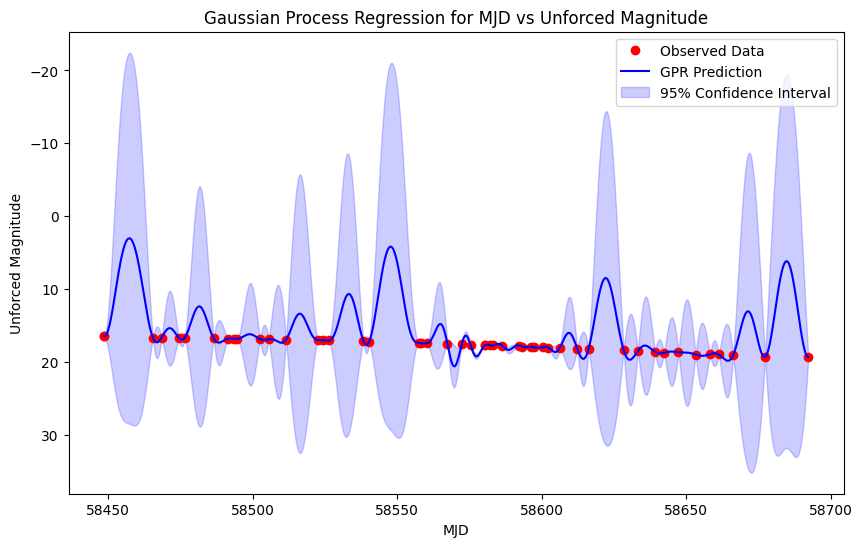

Maximum y-value: 20.634435969748665
At MJD: 58692.166678


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'ro', label="Observed Data")  # Original data points
plt.plot(X_test, y_pred, 'b-', label="GPR Prediction")  # Mean prediction
sigma = np.sqrt(np.diag(covariance))
plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label="95% Confidence Interval")
plt.xlabel("MJD")
plt.ylabel("Unforced Magnitude")
plt.gca().invert_yaxis()
plt.title("Gaussian Process Regression for MJD vs Unforced Magnitude")
plt.legend()
plt.show()
max_y = np.max(y_pred)
max_x = np.max(X_test)
print(f"Max at: {max_y}")
print(f"At MJD: {max_x}")

Which SN LightCurve do you wish to view?
enter SN name- SN2018imf


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


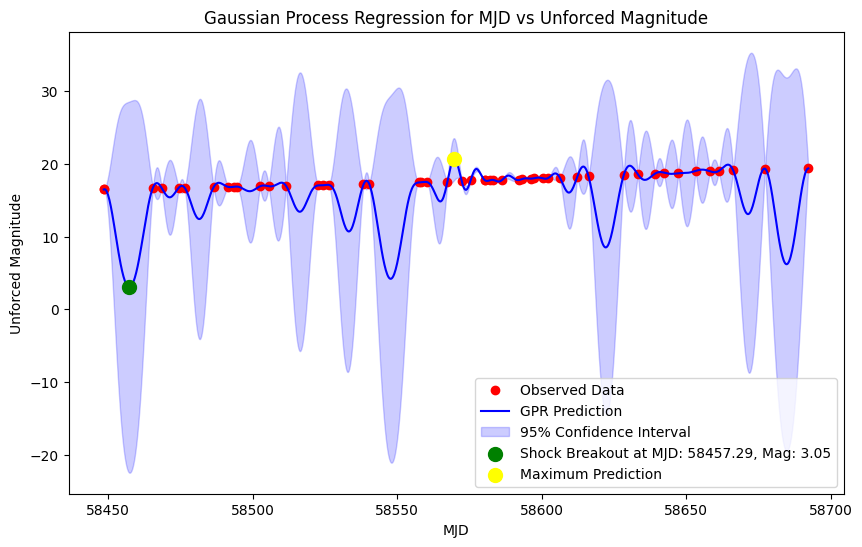

Max at: 20.634460240597036 At MJD: [58569.73031516]
Shock Breakout at: 3.051148513927662 at MJD: 58457.29373493694


In [ ]:
# test run with standard deviation, Constant Kernel and RBF Kernel

print("Which SN LightCurve do you wish to view?")
SN_name = input("enter SN name- ")
file = SN_name + "_frg_r.csv"
frg_r = pd.read_csv(file)


# training data set
X = frg_r[['MJD']].values
y = frg_r[['unforced_mag']].values

# define the kernel and set up the GPR
# Constant Kernel * RBF Kernel
kernelOne = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
# Initialize Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernelOne, n_restarts_optimizer=10, random_state=42)

# Fit to the data
gpr.fit(X, y)

# predicted data set
X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Function to find local extrema in the predicted values
def find_local_extrema(arr, X_test):
    for i in range(2, len(arr) - 1):
        # Check if the current value is a local maxima or minima
        if arr[i] > arr[i-1] and arr[i] > arr[i+1]:  # local maxima
            return (X_test[i][0], arr[i], 'max')
        elif arr[i] < arr[i-1] and arr[i] < arr[i+1]:  # local minima
            return (X_test[i][0], arr[i], 'min')
    return None

# Find the first local extremum (max or min) in the predicted values
extrema = find_local_extrema(y_pred, X_test)


# Find the maximum predicted value and its corresponding X_test value
max_y = np.max(y_pred)
max_x = X_test[np.argmax(y_pred)]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'ro', label="Observed Data")  # Original data points
plt.plot(X_test, y_pred, 'b-', label="GPR Prediction")  # Mean prediction
plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label="95% Confidence Interval")

# Highlight the local maximum or minimum point
if extrema:
    ex_x, ex_y, ex_type = extrema
    plt.scatter(ex_x, ex_y, color='green', s=100, label=f"Shock Breakout at MJD: {ex_x:.2f}, Mag: {ex_y:.2f}", zorder=5)

# Highlight the maximum point
plt.scatter(max_x, max_y, color='yellow', s=100, label="Maximum Prediction", zorder=5)

plt.xlabel("MJD")
plt.ylabel("Unforced Magnitude")
#plt.gca().invert_yaxis()
plt.title("Gaussian Process Regression for MJD vs Unforced Magnitude")
plt.legend()
plt.show()

# Print the results
print(f"Max at: {max_y} At MJD: {max_x}")
if extrema:
    ex_x, ex_y, ex_type = extrema
    print(f"Shock Breakout at: {ex_y} at MJD: {ex_x}")
else:
    print("No local extrema found.")


Which SN LightCurve do you wish to view?
enter SN name- SN2023mpz


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


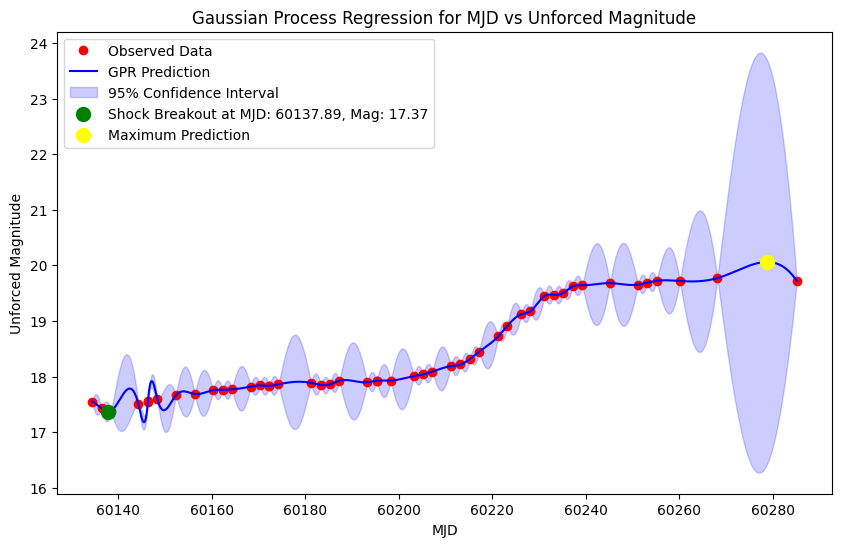

Max at: 20.061109023232348 At MJD: [60278.79728854]
Shock Breakout at: 17.367975600529462 at MJD: 60137.89185891992


In [4]:
#test run with STD, C and Matern

print("Which SN LightCurve do you wish to view?")
SN_name = input("enter SN name- ")
file = SN_name + "_frg_r.csv"
frg_r = pd.read_csv(file)


# training data set
X = frg_r[['MJD']].values
y = frg_r[['unforced_mag']].values

# define the kernel and set up the GPR
# Constant Kernel * Matern Kernel
kernelTwo = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)
# Initialize Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernelTwo, n_restarts_optimizer=10, random_state=42)

# Fit to the data
gpr.fit(X, y)

# predicted data set
X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Function to find local extrema in the predicted values
def find_local_extrema(arr, X_test):
    for i in range(2, len(arr) - 1):
        # Check if the current value is a local maxima or minima
        if arr[i] > arr[i-1] and arr[i] > arr[i+1]:  # local maxima
            return (X_test[i][0], arr[i], 'max')
        elif arr[i] < arr[i-1] and arr[i] < arr[i+1]:  # local minima
            return (X_test[i][0], arr[i], 'min')
    return None

# Find the first local extremum (max or min) in the predicted values
extrema = find_local_extrema(y_pred, X_test)


# Find the maximum predicted value and its corresponding X_test value
max_y = np.max(y_pred)
max_x = X_test[np.argmax(y_pred)]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'ro', label="Observed Data")  # Original data points
plt.plot(X_test, y_pred, 'b-', label="GPR Prediction")  # Mean prediction
plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label="95% Confidence Interval")

# Highlight the local maximum or minimum point
if extrema:
    ex_x, ex_y, ex_type = extrema
    plt.scatter(ex_x, ex_y, color='green', s=100, label=f"Shock Breakout at MJD: {ex_x:.2f}, Mag: {ex_y:.2f}", zorder=5)

# Highlight the maximum point
plt.scatter(max_x, max_y, color='yellow', s=100, label="Maximum Prediction", zorder=5)

plt.xlabel("MJD")
plt.ylabel("Unforced Magnitude")
#plt.gca().invert_yaxis()
plt.title("Gaussian Process Regression for MJD vs Unforced Magnitude")
plt.legend()
plt.show()


# Print the results
print(f"Max at: {max_y} At MJD: {max_x}")
if extrema:
    ex_x, ex_y, ex_type = extrema
    print(f"Shock Breakout at: {ex_y} at MJD: {ex_x}")
else:
    print("No local extrema found.")

Which SN LightCurve do you wish to view?
enter SN name- SN2023mpz


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


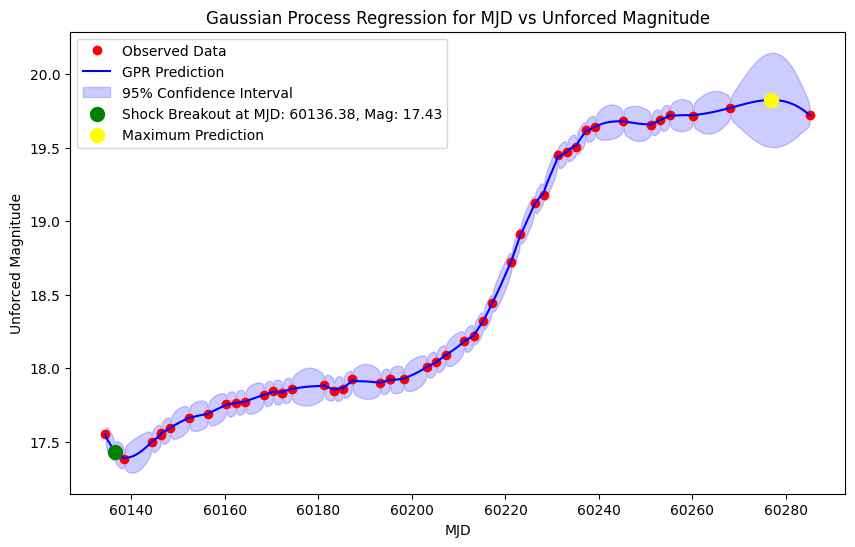

Max of: 19.82528654049861 At MJD: [60276.83607806]
Shock Breakout of: 17.42938710427825 at MJD: 60136.383235476475


In [8]:
  #test run with STD and different types of kernels

print("Which SN LightCurve do you wish to view?")
SN_name = input("enter SN name- ")
file = SN_name + "_frg_r.csv"
frg_r = pd.read_csv(file)


# training data set
X = frg_r[['MJD']].values
y = frg_r[['unforced_mag']].values

# define the kernel and set up the GPR
kernelThree = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)
kernelFour = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernelFive = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernelSix = C(1.0, (1e-3, 1e3)) * RQ(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-2, 1e2), alpha_bounds=(1e-5, 1e5))
kernelSeven = C(1.0, (1e-3, 1e3)) * RQ(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-2, 1e2), alpha_bounds=(1e-5, 1e5))* Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)
kernelEight = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-05, 1e5))

# note --> adding a white kernel to kernelFive(C*Matern*RBF) just basically turns it into kernelSeven (C*RQ*Matern)

# Initialize Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernelSeven, n_restarts_optimizer=10, random_state=42)

# Fit to the data
gpr.fit(X, y)

# predicted data set
X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Function to find local extrema in the predicted values
def find_local_extrema(arr, X_test):
    for i in range(2, len(arr) - 1):
        # Check if the current value is a local maxima or minima
        if arr[i] > arr[i-1] and arr[i] > arr[i+1]:  # local maxima
            return (X_test[i][0], arr[i], 'max')
        elif arr[i] < arr[i-1] and arr[i] < arr[i+1]:  # local minima
            return (X_test[i][0], arr[i], 'min')
    return None

# Find the first local extremum (max or min) in the predicted values
extrema = find_local_extrema(y_pred, X_test)


# Find the maximum predicted value and its corresponding X_test value
max_y = np.max(y_pred)
max_x = X_test[np.argmax(y_pred)]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'ro', label="Observed Data")  # Original data points
plt.plot(X_test, y_pred, 'b-', label="GPR Prediction")  # Mean prediction
plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label="95% Confidence Interval")

# Highlight the local maximum or minimum point
if extrema:
    ex_x, ex_y, ex_type = extrema
    plt.scatter(ex_x, ex_y, color='green', s=100, label=f"Shock Breakout at MJD: {ex_x:.2f}, Mag: {ex_y:.2f}", zorder=5)

# Highlight the maximum point
plt.scatter(max_x, max_y, color='yellow', s=100, label="Maximum Prediction", zorder=5)

plt.xlabel("MJD")
plt.ylabel("Unforced Magnitude")
#plt.gca().invert_yaxis()
plt.title("Gaussian Process Regression for MJD vs Unforced Magnitude")
plt.legend()
plt.show()


# Print the results
print(f"Max of: {max_y} At MJD: {max_x}")
if extrema:
    ex_x, ex_y, ex_type = extrema
    print(f"Shock Breakout of: {ex_y} at MJD: {ex_x}")
else:
    print("No local extrema found.")